In [1]:
import pandas as pd
import numpy as np
import re
import math

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder
from sklearn.decomposition import PCA


In [2]:
# Set path where file is located
path = 'data/CreateEAJob/PCC_Info.log(2).6'

# Initiate empty lists & dictionary to store contents
time, thread, level, content = ([] for i in range(4))
data = {}

# Define Regex Pattern for manufacturing log files
pattern = re.compile('^([0-9\- :,]{23})\s*\[(\S*)\]\s*(\S*)\s*(.*)')

# Read log file as input
log_data = open(path, 'r')
line = log_data.readline()

while line:
    try:
        # Only read the first line that starts with timestamp, as subsequent line have many noises
        if re.match(r'^[0-9]{4}-[0-9]{2}-[0-9]{2}\s[0-9]{2}:[0-9]{2}:[0-9]{2},[0-9]{3}', line):
            time.append(pattern.match(line).group(1))
            thread.append(pattern.match(line).group(2))
            level.append(pattern.match(line).group(3))
            content.append(pattern.match(line).group(4))
    except ValueError:
        print('Error in line :' + line)
    line = log_data.readline()

data["time"] = time
data["thread"] = thread
data["level"] = level
data["content"] = content

# Generate dataframe from 'data' dictionary
df_main = pd.DataFrame.from_dict(data)
df_main


,time,thread,level,content
0,"2020-10-15 16:18:01,754",1,INFO,Eaf.Core.Logging.LoggingSetupManager - Logging...
1,"2020-10-15 16:18:01,755",1,INFO,Eaf.Core.BackboneFactory - Start configured lo...
2,"2020-10-15 16:18:01,755",1,INFO,Eaf.Core.BackboneFactory - EAF Version 3.18.2.0
3,"2020-10-15 16:18:01,755",1,INFO,Eaf.Core.BackboneFactory - Current Process ID:...
4,"2020-10-15 16:18:01,755",1,INFO,Eaf.Core.BackboneFactory - Configuration type:...
...,...,...,...,...
13262,"2020-10-15 16:25:11,890",Queue.Package:13,INFO,Eaf.FactoryConnector.AisEda.Component.EdaAdapt...
13263,"2020-10-15 16:25:11,890",Queue.Package:13,INFO,Eaf.EquipmentCore.TraceJoin.Component.TraceJoi...
13264,"2020-10-15 16:25:11,890",Queue.Package:13,INFO,EventPerformance.EdaAdapter_TraceMerge - Packa...
13265,"2020-10-15 16:25:11,890",Queue.Package:18,INFO,Eaf.Yoda.YodaAdapter::YodaAdapter_EI_View - Ha...


In [3]:
# Turn 'time' column to datetime format
df_main["time"] = pd.to_datetime(df_main["time"])


In [4]:
df_main.describe()


C:\Users\tangkaiv\AppData\Local\Temp/ipykernel_5564/3930277524.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_main.describe()


,time,thread,level,content
count,13267,13267,13267,13267
unique,2912,119,4,11676
top,2020-10-15 16:18:13.302000,Queue.Package:14,INFO,Ifx.Eaf.EquipmentConnector.TCP.Component.Gener...
freq,33,2283,12750,179
first,2020-10-15 16:18:01.754000,NaN,NaN,NaN
last,2020-10-15 16:25:11.890000,NaN,NaN,NaN


In [5]:
# Split 'content' into 'classes' and 'message' for further analysis

df_main["classes"] = df_main['content'].str.split("-", n = 1, expand = True)[0]

df_main["message"] = df_main['content'].str.split("-", n = 1, expand = True)[1]

df_main.drop(columns =["content", "thread"], inplace = True)

df_main


,time,level,classes,message
0,2020-10-15 16:18:01.754,INFO,Eaf.Core.Logging.LoggingSetupManager,Logging configuration successfully updated fr...
1,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Start configured logging of EAF Backbone.
2,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,EAF Version 3.18.2.0
3,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Current Process ID: 25996
4,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Configuration type: WCF
...,...,...,...,...
13262,2020-10-15 16:25:11.890,INFO,Eaf.FactoryConnector.AisEda.Component.EdaAdapt...,Received package Event_637383466822711587.1.1...
13263,2020-10-15 16:25:11.890,INFO,Eaf.EquipmentCore.TraceJoin.Component.TraceJoi...,Processing complete. [PackageID:Event_6373834...
13264,2020-10-15 16:25:11.890,INFO,EventPerformance.EdaAdapter_TraceMerge,Package history for Event_637383466822711587....
13265,2020-10-15 16:25:11.890,INFO,Eaf.Yoda.YodaAdapter::YodaAdapter_EI_View,Handle Event_637383466822711587.1.1.1.1


<AxesSubplot:>

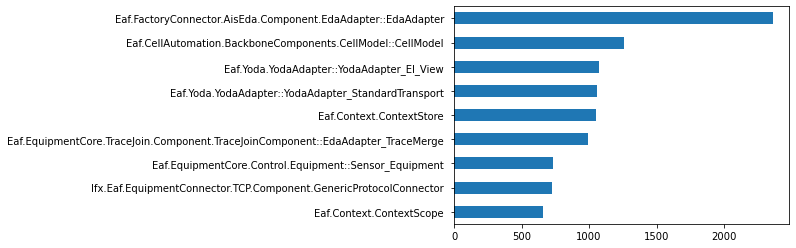

In [6]:
# Calculate the top 10% classes in this logging
top_class_count = math.ceil(len(df_main["classes"].value_counts()) * 0.1)

# Visualize the top classes in bar chart
df_main["classes"].value_counts().nlargest(top_class_count).sort_values().plot(kind = 'barh')


In [7]:
# Declare var before data preprocessing
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')
newStopWords = ['eaf', 'ifx', 'field', 'document', 'name', 'materialinfo',
                'materialname', 'material', 'slotnumber', 'property', 'value',
                'optional']
stopwords.extend(newStopWords)


In [8]:
# Preprocess function that turn sentence into tokens
def preprocess(sentence):

    # Turn sentence into string
    sentence = str(sentence)

    # Turn sentence into lowercase
    sentence = sentence.lower()

    # Remove unique object ID
    rem_msg_id = re.sub('(([a-z0-9]+-){4}[a-z0-9]+)', '', sentence)

    # Remove remaining ID
    rem_trans_id = re.sub('\sid=\S*', '', rem_msg_id)

    # Remove all digits
    rem_dig = re.sub('\d+', '', rem_trans_id)

    # Tokeniz but include abc_def or abc-def
    tokenizer = RegexpTokenizer(r'[a-z-]{3,}')
    tokens = tokenizer.tokenize(rem_dig)

    # Lemmatize all token
    lemma_words = [lemmatizer.lemmatize(w) for w in tokens]

    # Remove stopwords
    rem_stopwords = [w for w in lemma_words if w not in stopwords]

    # Remove duplicate
    rem_duplicate = list(set(rem_stopwords))

    return " ".join(rem_duplicate)


In [9]:
# Preprocess 'message' column to tokens in 'filter_message'
df_main['filter_message'] = df_main['message'].map(lambda y: preprocess(y))
df_main


,time,level,classes,message,filter_message
0,2020-10-15 16:18:01.754,INFO,Eaf.Core.Logging.LoggingSetupManager,Logging configuration successfully updated fr...,backbone successfully configuration logging up...
1,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Start configured logging of EAF Backbone.,backbone start configured logging
2,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,EAF Version 3.18.2.0,version
3,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Current Process ID: 25996,current process
4,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Configuration type: WCF,type configuration wcf
...,...,...,...,...,...
13262,2020-10-15 16:25:11.890,INFO,Eaf.FactoryConnector.AisEda.Component.EdaAdapt...,Received package Event_637383466822711587.1.1...,size received event package queue
13263,2020-10-15 16:25:11.890,INFO,Eaf.EquipmentCore.TraceJoin.Component.TraceJoi...,Processing complete. [PackageID:Event_6373834...,complete event packageid processing
13264,2020-10-15 16:25:11.890,INFO,EventPerformance.EdaAdapter_TraceMerge,Package history for Event_637383466822711587....,start processing size sensor time dequeued eda...
13265,2020-10-15 16:25:11.890,INFO,Eaf.Yoda.YodaAdapter::YodaAdapter_EI_View,Handle Event_637383466822711587.1.1.1.1,event handle


The idea is to duplicate and split dataframe into several dataset to see which one give us the best result. <br> 
They will be splitted into the following categories: <br> 
&emsp;- main (Contains everything) <br> 
&emsp;- info (INFO-level only) <br> 
&emsp;- error (WARN + FATAL level) <br> 
&emsp;- selected timeframe (Based on experience when the issue happen) <br> 
&emsp;- selected timeframe + info <br> 
&emsp;- selected timeframe + error <br> 
&emsp;- top 10% classes <br> 


In [10]:
# Created a list of categories
df_category_list = ['main', 'info', 'error', 'selected_time', 'selected_time_info', 'selected_time_error']
for x in range(top_class_count): df_category_list.append('class'+str(x+1))
df_category_list


['main',
 'info',
 'error',
 'selected_time',
 'selected_time_info',
 'selected_time_error',
 'class1',
 'class2',
 'class3',
 'class4',
 'class5',
 'class6',
 'class7',
 'class8',
 'class9']

In [11]:
# Split & Duplicate data
start_time = '2020-10-15 16:21:43'
end_time = '2020-10-15 16:22:43'
df_class = {}

df_info = df_main[df_main.level == "INFO"]

df_error = df_main[(df_main.level == "WARN") | (df_main.level == "FATAL")]

df_time = df_main[(df_main["time"] > start_time) &
                  (df_main["time"] < end_time)]

df_time_info = df_main[(df_main["time"] > start_time) &
                       (df_main["time"] < end_time) &
                       (df_main.level == "INFO")]

df_time_error = df_main[(df_main["time"] > start_time) &
                        (df_main["time"] < end_time) &
                        ((df_main.level == "WARN") | (df_main.level == "FATAL"))]

df_list = [df_main, df_info, df_error, df_time, df_time_info, df_time_error]

for x in list(df_main["classes"].value_counts().nlargest(top_class_count).index):
    df_class[x] = df_main[df_main["classes"] == x]
    df_list.append(df_class[x])

stacked_df = pd.concat([df.assign(category = category) for df, category in zip(df_list, df_category_list)])
stacked_df


,time,level,classes,message,filter_message,category
0,2020-10-15 16:18:01.754,INFO,Eaf.Core.Logging.LoggingSetupManager,Logging configuration successfully updated fr...,backbone successfully configuration logging up...,main
1,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Start configured logging of EAF Backbone.,backbone start configured logging,main
2,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,EAF Version 3.18.2.0,version,main
3,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Current Process ID: 25996,current process,main
4,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Configuration type: WCF,type configuration wcf,main
...,...,...,...,...,...,...
12937,2020-10-15 16:25:02.217,INFO,Eaf.Context.ContextScope,Removing object with id : 35196.1 and type : ...,automationinterface iprocessjob teocent scope ...,class9
12939,2020-10-15 16:25:02.217,INFO,Eaf.Context.ContextScope,Removing object from list with id : 35196 and...,automationinterface teocent list icontroljob s...,class9
12940,2020-10-15 16:25:02.217,INFO,Eaf.Context.ContextScope,Removing object with id : 35196 and type : Ea...,automationinterface teocent icontroljob scope ...,class9
12948,2020-10-15 16:25:02.218,INFO,Eaf.Context.ContextScope,Removing object from list with id : 35196 and...,list infineon scope applicationlogic removing ...,class9


In [12]:
# Select main data for visualization
dataframe = stacked_df.groupby(['category']).get_group('main')
dataframe


,time,level,classes,message,filter_message,category
0,2020-10-15 16:18:01.754,INFO,Eaf.Core.Logging.LoggingSetupManager,Logging configuration successfully updated fr...,backbone successfully configuration logging up...,main
1,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Start configured logging of EAF Backbone.,backbone start configured logging,main
2,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,EAF Version 3.18.2.0,version,main
3,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Current Process ID: 25996,current process,main
4,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Configuration type: WCF,type configuration wcf,main
...,...,...,...,...,...,...
13262,2020-10-15 16:25:11.890,INFO,Eaf.FactoryConnector.AisEda.Component.EdaAdapt...,Received package Event_637383466822711587.1.1...,size received event package queue,main
13263,2020-10-15 16:25:11.890,INFO,Eaf.EquipmentCore.TraceJoin.Component.TraceJoi...,Processing complete. [PackageID:Event_6373834...,complete event packageid processing,main
13264,2020-10-15 16:25:11.890,INFO,EventPerformance.EdaAdapter_TraceMerge,Package history for Event_637383466822711587....,start processing size sensor time dequeued eda...,main
13265,2020-10-15 16:25:11.890,INFO,Eaf.Yoda.YodaAdapter::YodaAdapter_EI_View,Handle Event_637383466822711587.1.1.1.1,event handle,main


In [13]:
# Define function to calculate unigram and bigram
def count_word_unigram(df):
    aggregate_counter = Counter()
    
    for row_index,row in df.iterrows():
        c = Counter(row['filter_message'].split())
        aggregate_counter += c
        
    return aggregate_counter

def count_word_bigram(df):
    c_vec = CountVectorizer(ngram_range=(2,2))
    
    # matrix of ngrams
    ngrams = c_vec.fit_transform(dataframe['filter_message'])
    
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    
    # list of ngrams
    vocab = c_vec.vocabulary_

    return vocab
    

In [14]:
# Count the unigrams and bigrams available in main dataset
result_unigram = count_word_unigram(dataframe)
result_bigram = count_word_bigram(dataframe)


In [15]:
# Find the most common unigram and bigram counts
common_unigram = [word[0] for word in result_unigram.most_common(50)]
common_unigram_counts = [word[1] for word in result_unigram.most_common(50)]

common_bigram = [word[0] for word in sorted(result_bigram.items(), key=itemgetter(1), reverse=True)[:50]]
common_bigram_counts = [word[1] for word in sorted(result_bigram.items(), key=itemgetter(1), reverse=True)[:50]]


In [16]:
# Define barplot function to plot graph
def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18, 6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()


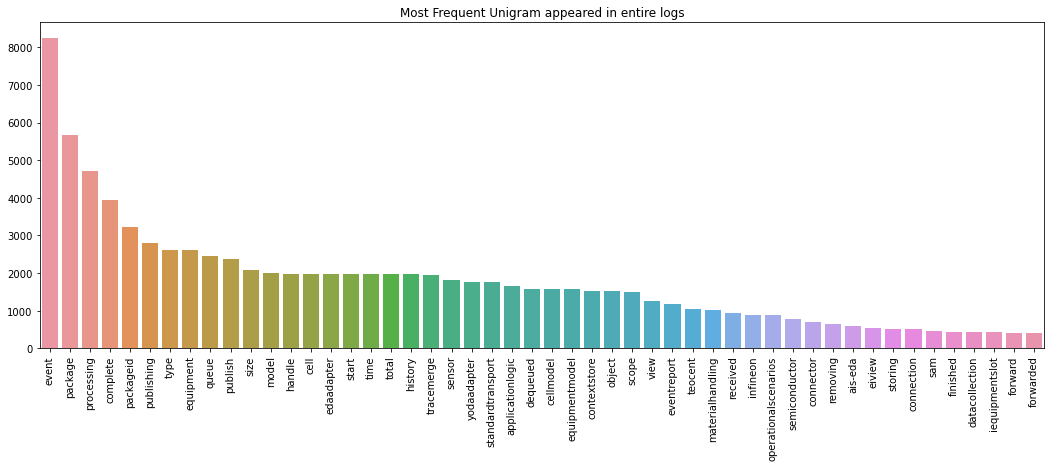

In [17]:
# Plot most frequent unigram in entire logs
barplot(words=common_unigram, words_counts=common_unigram_counts,
        title='Most Frequent Unigram appeared in entire logs')


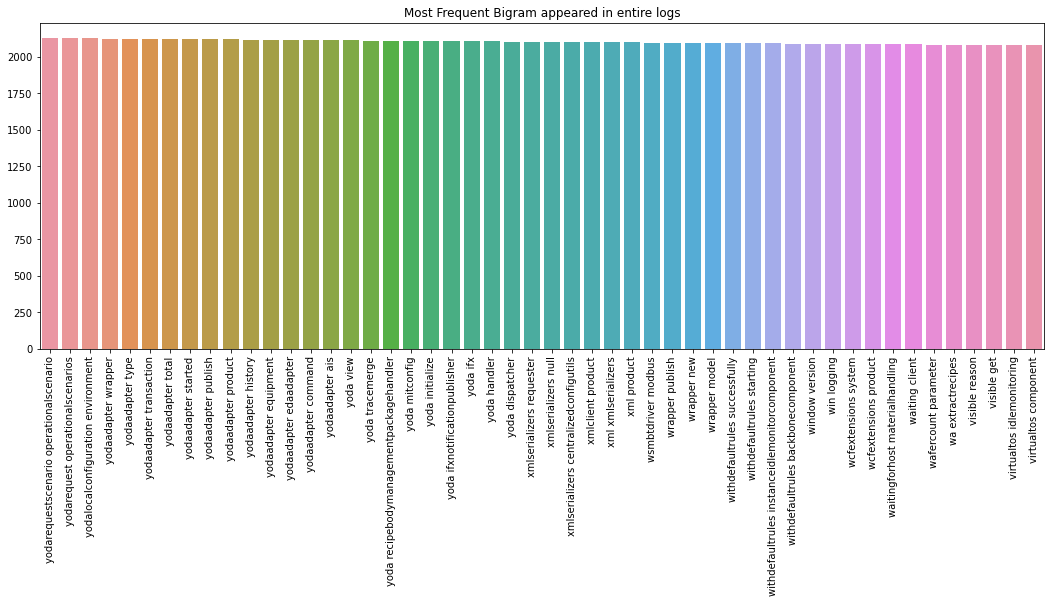

In [18]:
# Plot most frequent bigram in entire logs
barplot(words=common_bigram, words_counts=common_bigram_counts,
        title='Most Frequent Bigram appeared in entire logs')


In [19]:
# Find the most uncommon unigram and bigram counts
uncommon_unigram = [word[0] for word in result_unigram.most_common()[:-50:-1]]
uncommon_unigram_counts = [word[1] for word in result_unigram.most_common()[:-50:-1]]

uncommon_bigram = [word[0] for word in sorted(result_bigram.items(), key=itemgetter(1))[:50]]
uncommon_bigram_counts = [word[1] for word in sorted(result_bigram.items(), key=itemgetter(1))[:50]]


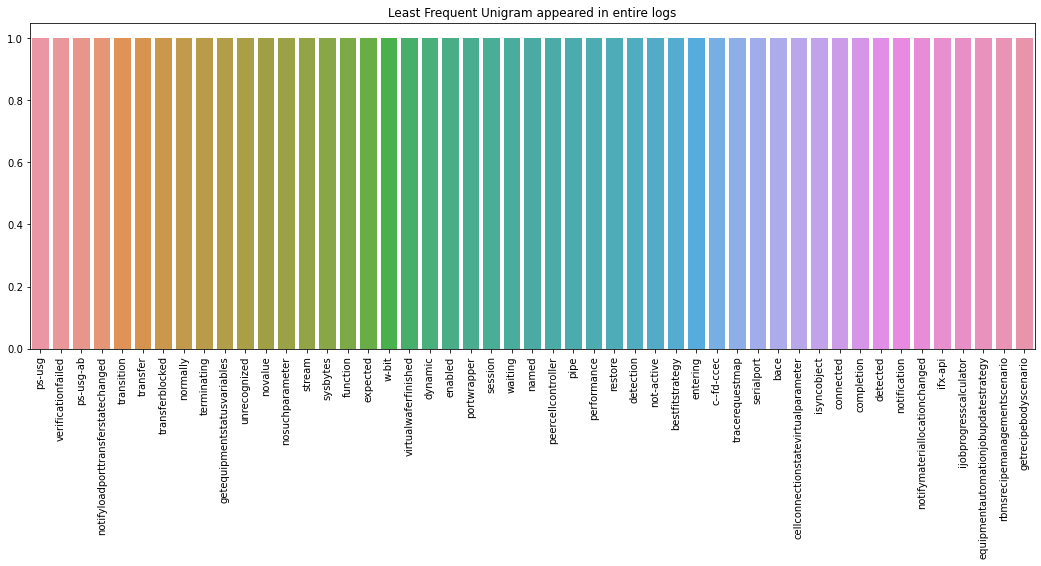

In [20]:
# Plot least frequent unigram in entire logs
barplot(words=uncommon_unigram, words_counts=uncommon_unigram_counts,
        title='Least Frequent Unigram appeared in entire logs')


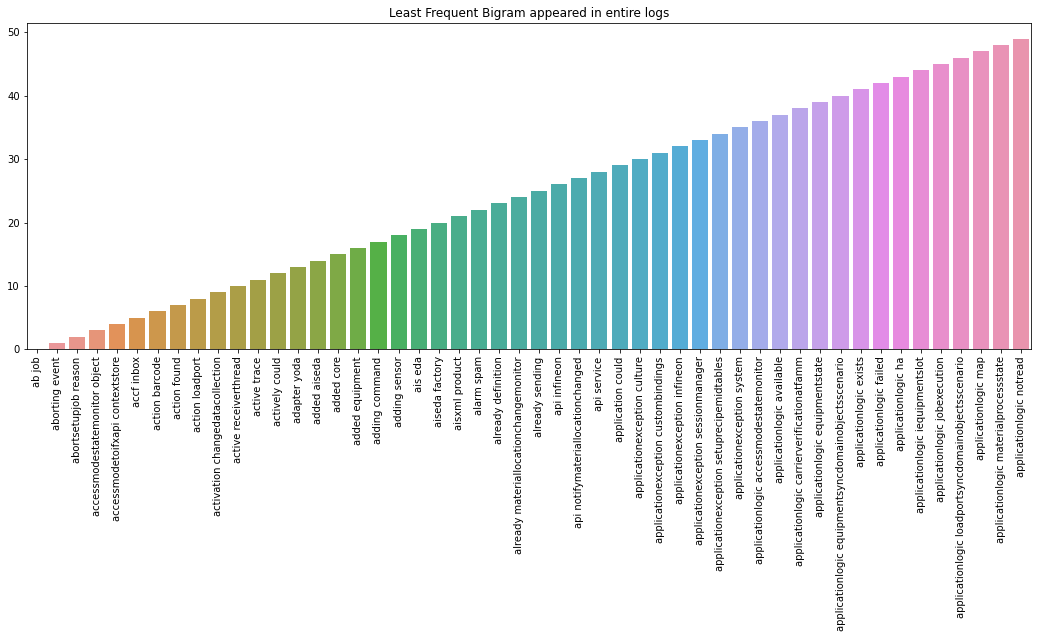

In [21]:
# Plot least frequent bigram in entire logs
barplot(words=uncommon_bigram, words_counts=uncommon_bigram_counts,
        title='Least Frequent Bigram appeared in entire logs')


In [22]:
# Copy an existing stack for douple preprocessing
stacked_df_2p = stacked_df.copy()


In [23]:
# Double Preprocess - Remove common stopwords
stacked_df_2p['filter_message'] = stacked_df_2p['filter_message'].map(lambda x:" ".join([y for y in x.split() if y not in common_unigram]))
stacked_df_2p['category'] = stacked_df_2p['category'] + "_2p"


In [24]:
# Calculate unigram and bigram after second preprocessing
df = stacked_df_2p.groupby(['category']).get_group('main_2p')

result_unigram = count_word_unigram(df)
result_bigram = count_word_bigram(df)

common_unigram = [word[0] for word in result_unigram.most_common(50)]
common_unigram_counts = [word[1] for word in result_unigram.most_common(50)]

common_bigram = [word[0] for word in sorted(result_bigram.items(), key=itemgetter(1), reverse=True)[:50]]
common_bigram_counts = [word[1] for word in sorted(result_bigram.items(), key=itemgetter(1), reverse=True)[:50]]

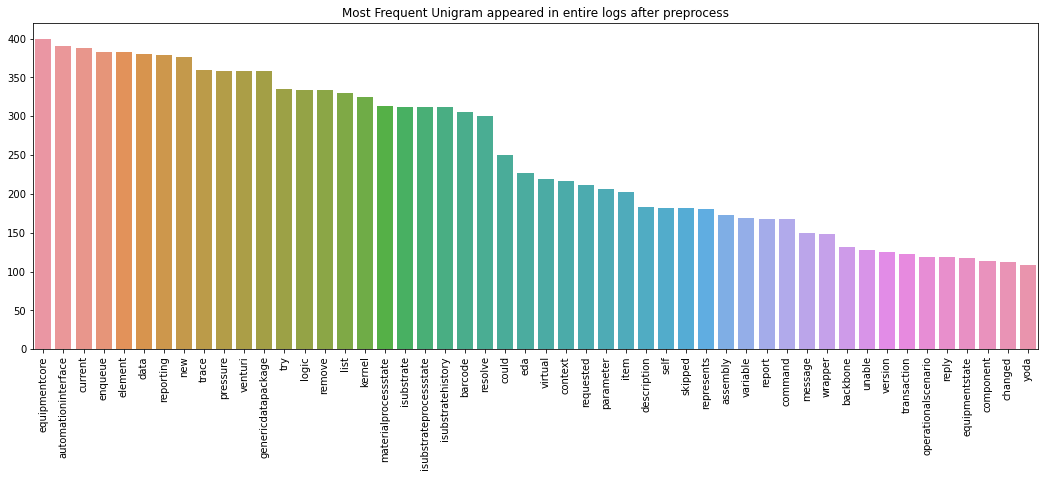

In [25]:
# Visualize most frequent unigram after second preprocessing
barplot(words=common_unigram, words_counts=common_unigram_counts, 
        title='Most Frequent Unigram appeared in entire logs after preprocess')


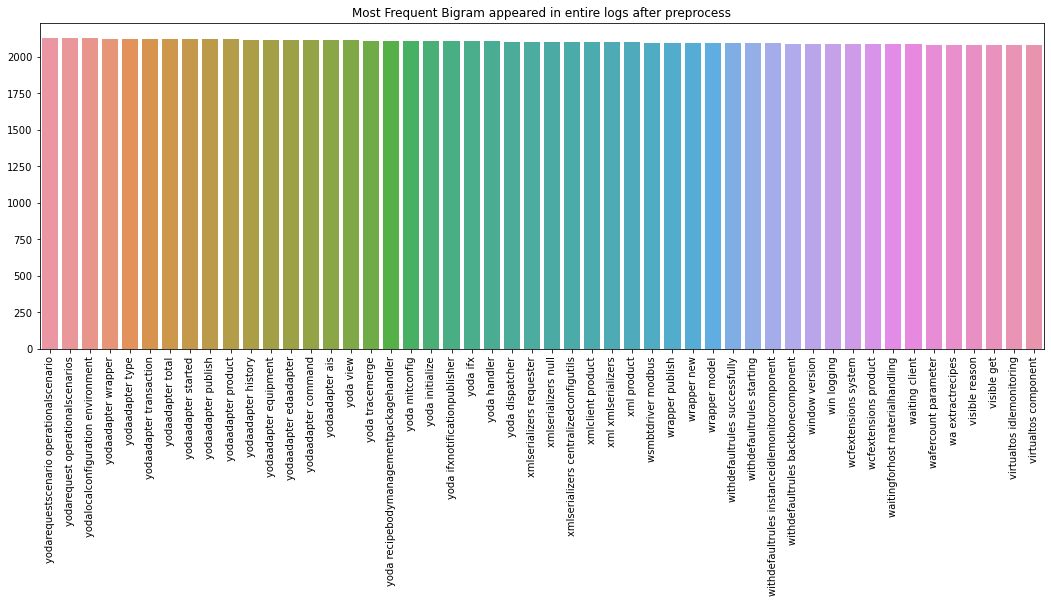

In [26]:
# Visualize most frequent bigram after second preprocessing
barplot(words=common_bigram, words_counts=common_bigram_counts, 
        title='Most Frequent Bigram appeared in entire logs after preprocess')


In [27]:
# Update category list to contain second preprocessing category
df_category_list_2p = df_category_list.copy()
df_category_list_2p = [s + "_2p" for s in df_category_list_2p]
df_category_list.extend(df_category_list_2p)
df_category_list


['main',
 'info',
 'error',
 'selected_time',
 'selected_time_info',
 'selected_time_error',
 'class1',
 'class2',
 'class3',
 'class4',
 'class5',
 'class6',
 'class7',
 'class8',
 'class9',
 'main_2p',
 'info_2p',
 'error_2p',
 'selected_time_2p',
 'selected_time_info_2p',
 'selected_time_error_2p',
 'class1_2p',
 'class2_2p',
 'class3_2p',
 'class4_2p',
 'class5_2p',
 'class6_2p',
 'class7_2p',
 'class8_2p',
 'class9_2p']

In [28]:
# Combine original dataset with second preprocessing dataset
stacked_df = stacked_df.append(stacked_df_2p)
stacked_df


C:\Users\tangkaiv\AppData\Local\Temp/ipykernel_5564/655607786.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stacked_df = stacked_df.append(stacked_df_2p)


,time,level,classes,message,filter_message,category
0,2020-10-15 16:18:01.754,INFO,Eaf.Core.Logging.LoggingSetupManager,Logging configuration successfully updated fr...,backbone successfully configuration logging up...,main
1,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Start configured logging of EAF Backbone.,backbone start configured logging,main
2,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,EAF Version 3.18.2.0,version,main
3,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Current Process ID: 25996,current process,main
4,2020-10-15 16:18:01.755,INFO,Eaf.Core.BackboneFactory,Configuration type: WCF,type configuration wcf,main
...,...,...,...,...,...,...
12937,2020-10-15 16:25:02.217,INFO,Eaf.Context.ContextScope,Removing object with id : 35196.1 and type : ...,automationinterface iprocessjob jobexecution,class9_2p
12939,2020-10-15 16:25:02.217,INFO,Eaf.Context.ContextScope,Removing object from list with id : 35196 and...,automationinterface list icontroljob jobexecution,class9_2p
12940,2020-10-15 16:25:02.217,INFO,Eaf.Context.ContextScope,Removing object with id : 35196 and type : Ea...,automationinterface icontroljob jobexecution,class9_2p
12948,2020-10-15 16:25:02.218,INFO,Eaf.Context.ContextScope,Removing object from list with id : 35196 and...,list jobexecution iequipmentautomationjob,class9_2p


In [29]:
# Declare TFIDF function to turn tokens into numbers
df_vectorized_list = []

def vectorize_df(df):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df['filter_message'])
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense()
    denselist = dense.tolist()
    df_vectorized_list.append(pd.DataFrame(denselist, columns=feature_names).set_index(df.index))


In [30]:
# Apply vectorized function to all tokens
for x in df_category_list:
    df = stacked_df.groupby(['category']).get_group(x)
    vectorize_df(df)


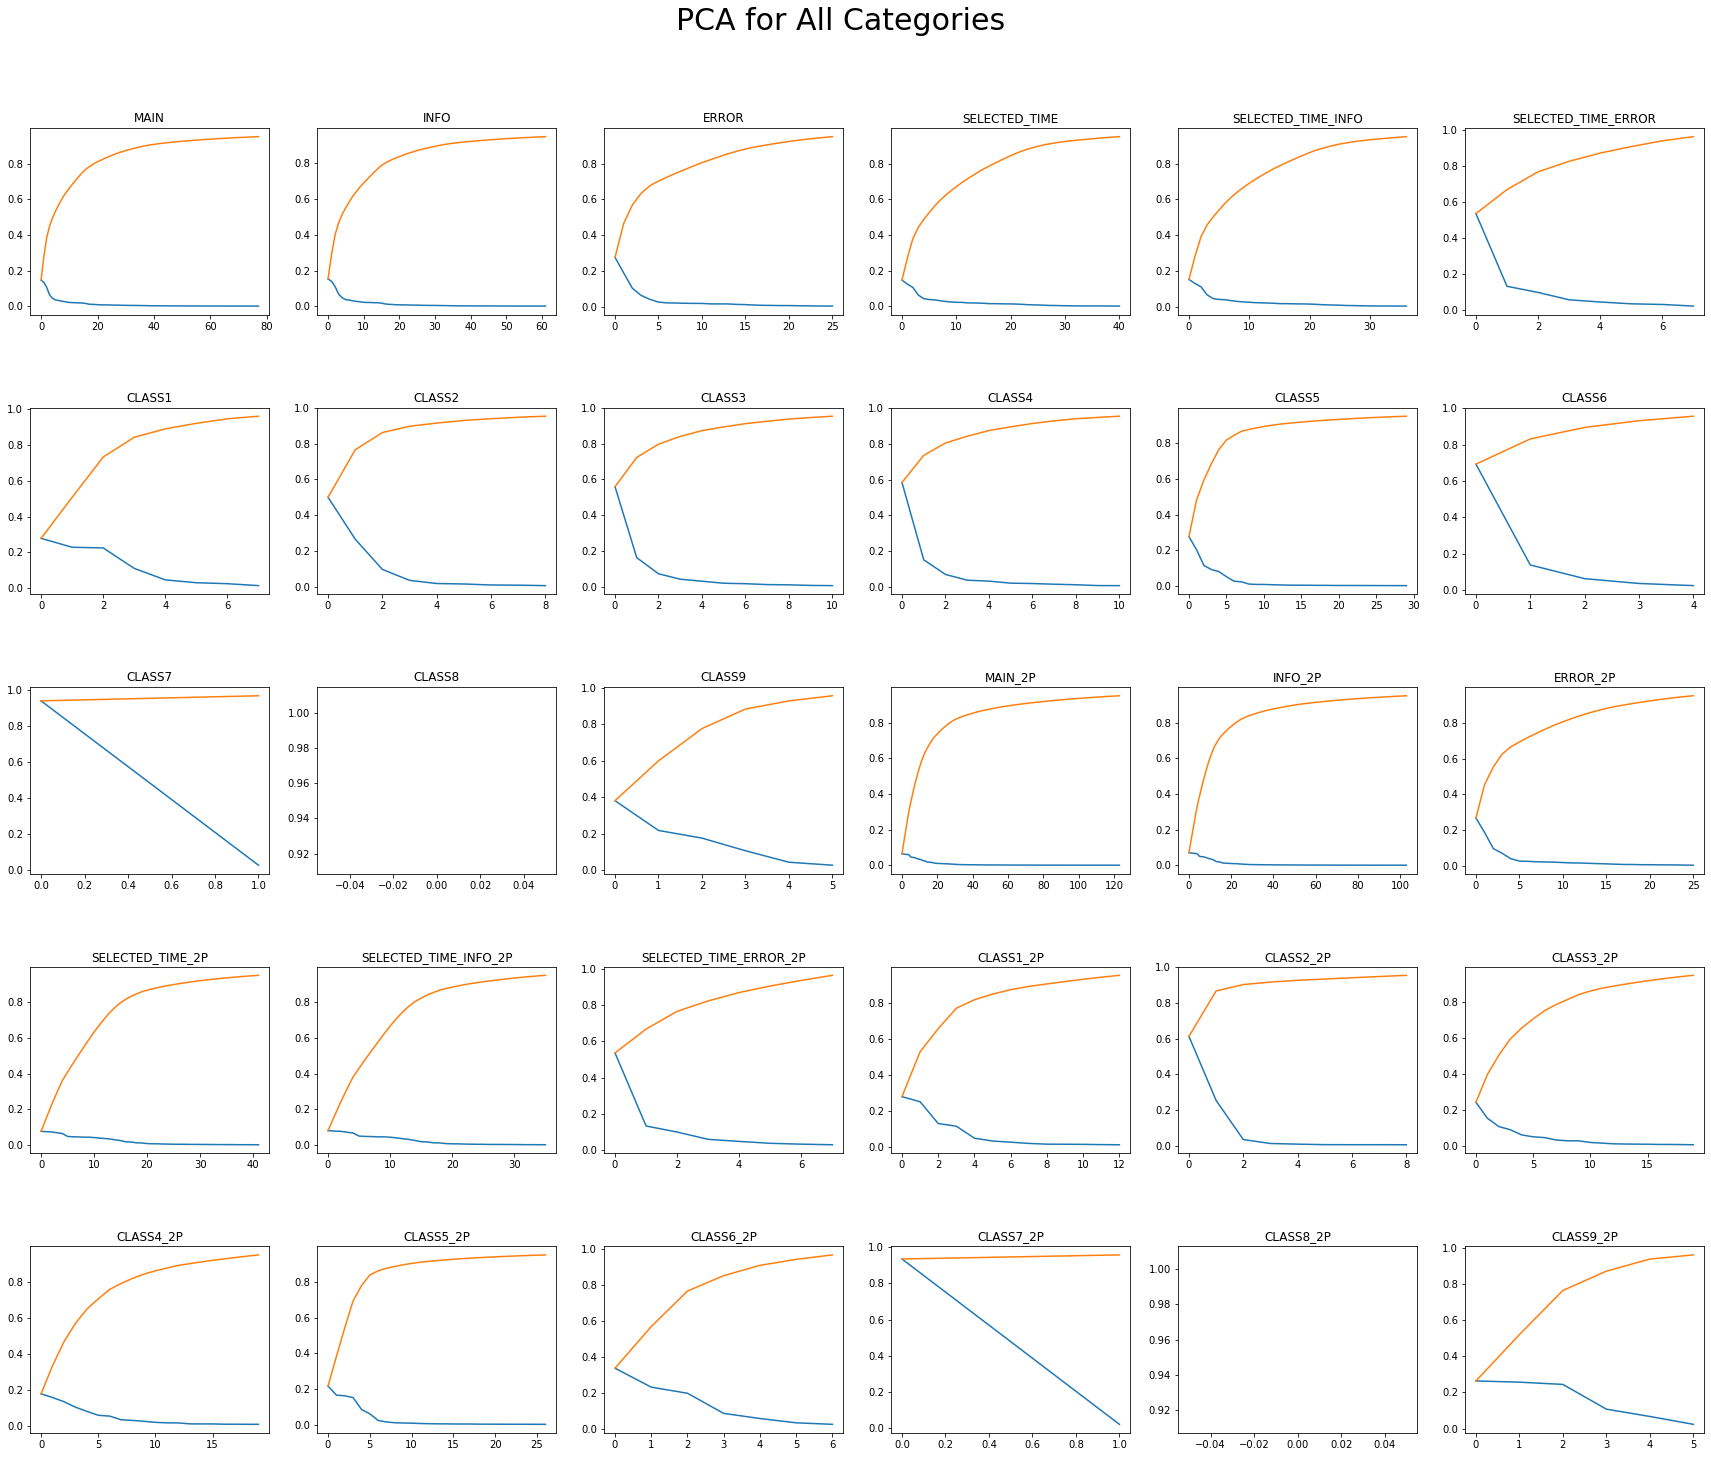

In [31]:
# Apply PCA and visualize the components
plt.figure(figsize=(30, 24))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("PCA for All Categories", fontsize=30, y=0.95)
df_pca = []

for n, x in enumerate(df_vectorized_list):
    ax = plt.subplot(5, 6, n + 1)
    pca = PCA(n_components=0.95, random_state = 42)
    pca_result = pca.fit_transform(x)
    df_pca.append(pca_result)
    plt.plot(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    
    # chart formatting
    ax.set_title(df_category_list[n].upper())


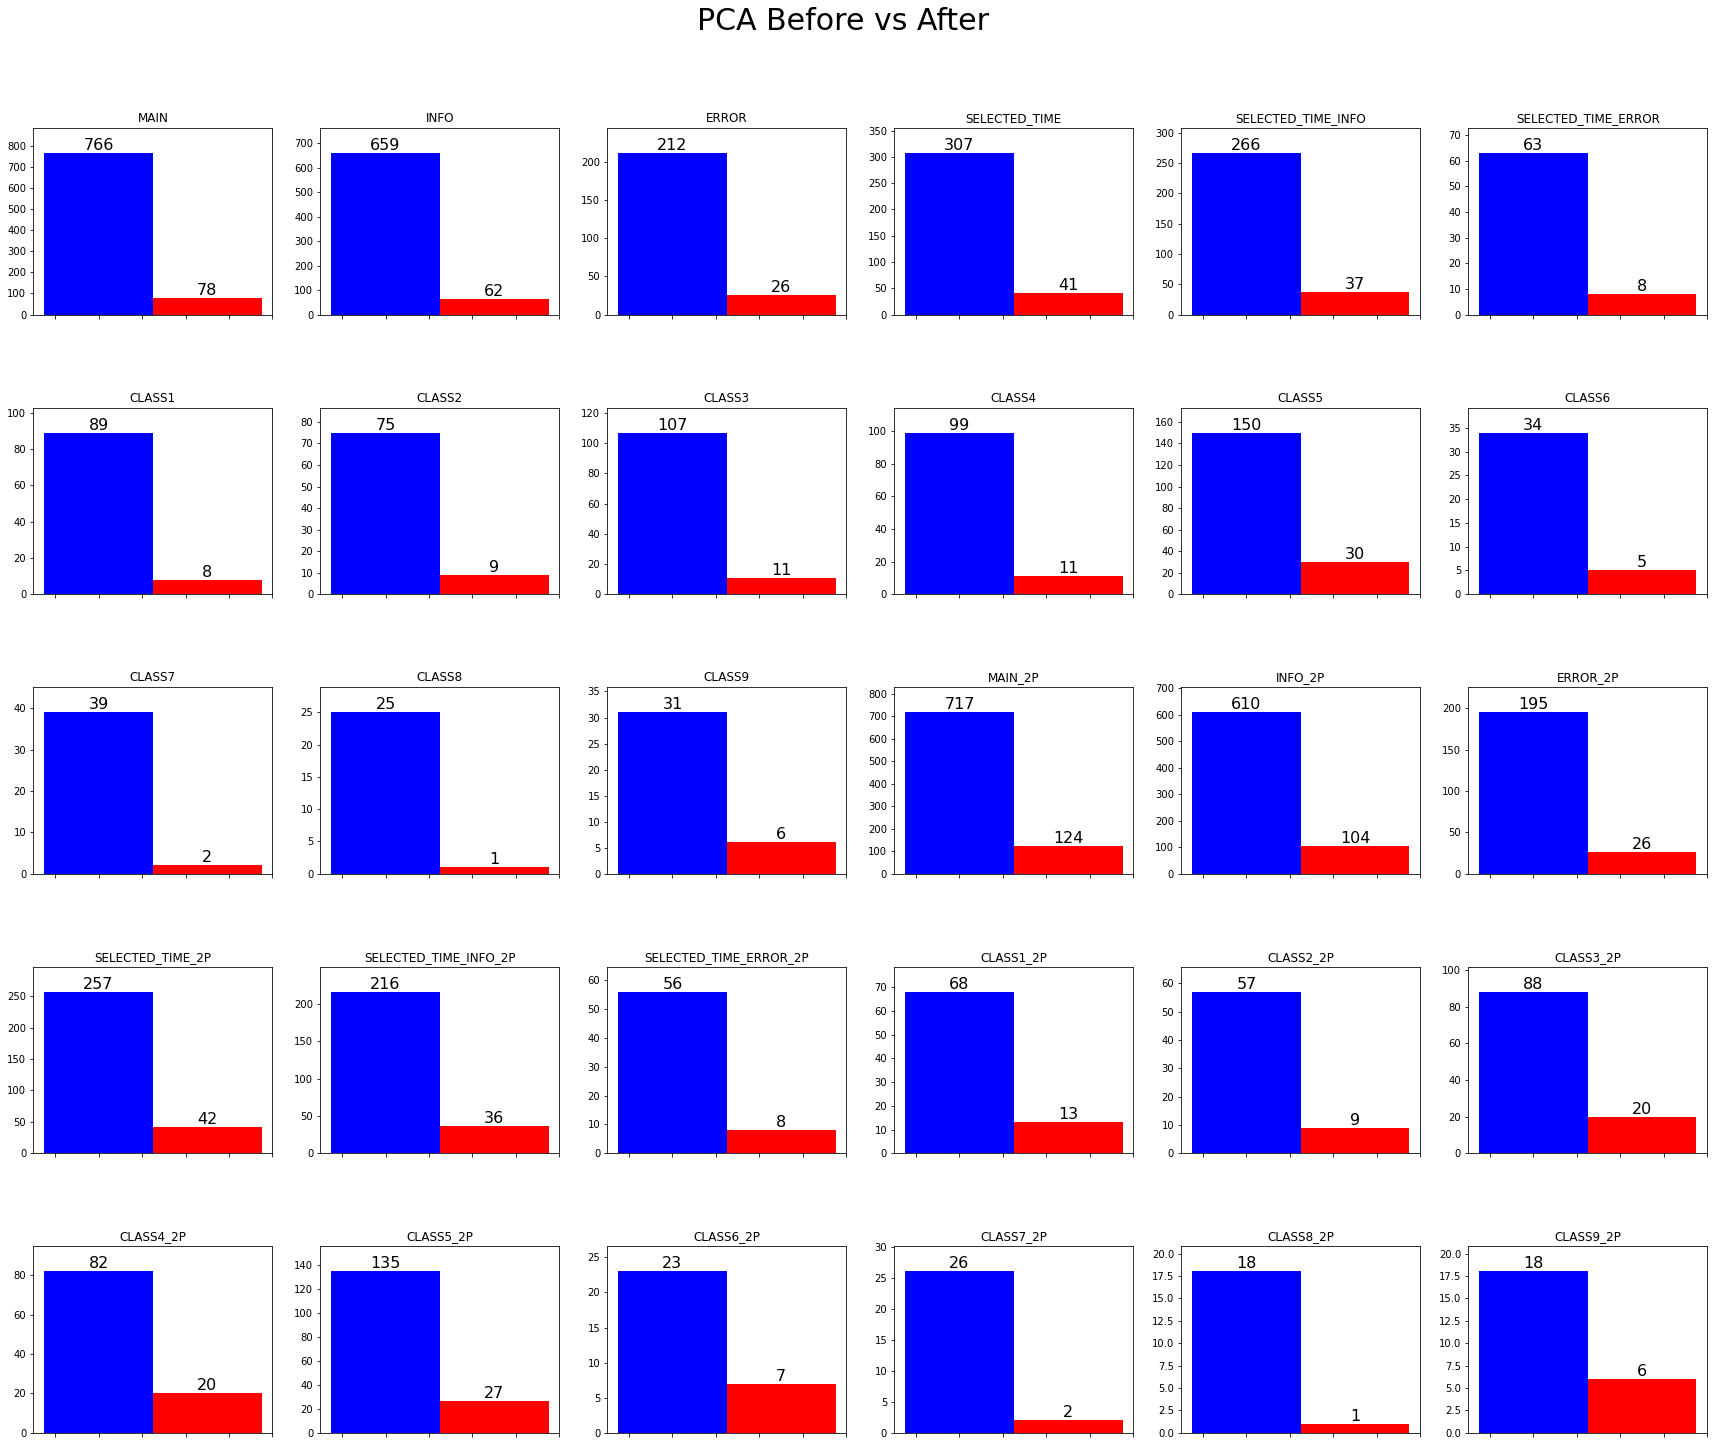

In [32]:
plt.figure(figsize=(30, 24))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("PCA Before vs After", fontsize=30, y=0.95)

before = []
after = []

for n in range(30):
    ax = plt.subplot(5, 6, n + 1)
    before.append(df_vectorized_list[n].shape[1])
    after.append(df_pca[n].shape[1])
    width = 0.25
    rect1 = ax.bar(n, before[n], color='b', width = width)
    rect2 = ax.bar(n+width, after[n], color='r', width = width)

    ax.bar_label(rect1, fontsize=16)
    ax.bar_label(rect2, fontsize=16)
    # chart formatting
    ax.set_title(df_category_list[n].upper())
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0,ymax*1.1)
    
    ax.set_xticklabels([])

In [33]:
# Declare all outlier detection model with 1% anomaly fraction
random_state = np.random.RandomState(42)
outliers_fraction = 0.01
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Auto Encoder': AutoEncoder(contamination=outliers_fraction, verbose=0)
}


In [34]:
# Loop through all the df_pca and pass in each classifiers to predict outlier
import time
data = []

for count,df in enumerate(df_pca):
    for clf_name, clf in classifiers.items():
        
        # Calculate time taken for each model
        start = time.time()
        
        # Skip model training for certain dataset that did not have enough columns
        if (clf_name == 'Feature Bagging' and df.shape[1] < 2) or (clf_name == 'Auto Encoder' and df.shape[1] < 32):
            continue
            
        # Fit df into classifier
        model = clf.fit(df)

        # Make prediction for the df
        predictions = model.predict(df)
        
        end = time.time()
        
        # Store a list of result that is consider outlier (Have value)
        result = list(df_vectorized_list[count].iloc[predictions != 0].index)
        
        # Select those result that appears only in the timeframe
        result_in_timeframe = list(set(df_time.index).intersection(result))
        
        # Store everything into a list
        data.append([df_category_list[count], clf_name, result, len(result), 
                     result_in_timeframe, len(result_in_timeframe), end-start])
    
df_result = pd.DataFrame(data, columns=["data", "method", "outlier_index", "outlier_found",
                                        "outlier_in_timeframe_index", "outlier_in_timeframe_found",
                                        "timetaken"])
df_result


C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3

C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3

C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3

C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tangkaiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\tangkaiv\Anaconda3

,data,method,outlier_index,outlier_found,outlier_in_timeframe_index,outlier_in_timeframe_found,timetaken
0,main,Angle-based Outlier Detector (ABOD),[],0,[],0,17.148328
1,main,Cluster-based Local Outlier Factor (CBLOF),[],0,[],0,2.766598
2,main,Feature Bagging,"[204, 362, 454, 553, 561, 565, 581, 620, 624, ...",108,"[5513, 5774, 5775, 5820, 5821, 6974, 5568, 556...",20,100.064440
3,main,Histogram-base Outlier Detection (HBOS),"[104, 105, 110, 128, 130, 133, 135, 137, 138, ...",122,"[6657, 6659, 6660, 6671, 6674, 6677, 6678, 668...",33,2.707087
4,main,Isolation Forest,"[104, 105, 135, 137, 145, 147, 157, 159, 168, ...",116,"[6657, 6659, 6660, 6666, 6671, 6674, 6677, 667...",33,5.570245
...,...,...,...,...,...,...,...
181,class9_2p,Cluster-based Local Outlier Factor (CBLOF),"[5878, 5932, 10422, 10873]",4,"[5932, 5878]",2,0.160667
182,class9_2p,Feature Bagging,"[10413, 10414, 10859, 10860]",4,[],0,0.148000
183,class9_2p,Histogram-base Outlier Detection (HBOS),"[8031, 8034, 10413, 10859, 12936, 12939]",6,"[8034, 8031]",2,0.004070
184,class9_2p,Isolation Forest,"[5878, 5932, 10422, 10873]",4,"[5932, 5878]",2,0.519042


In [35]:
# Declare result that we are looking for in the dataset, and check if they exist in outlier_index
result = [8022, 8023, 8024, 8026, 8027]
df_result["found"] = df_result.apply(lambda x:any (y in result for y in x["outlier_index"]),axis=1)
df_result


,data,method,outlier_index,outlier_found,outlier_in_timeframe_index,outlier_in_timeframe_found,timetaken,found
0,main,Angle-based Outlier Detector (ABOD),[],0,[],0,17.148328,False
1,main,Cluster-based Local Outlier Factor (CBLOF),[],0,[],0,2.766598,False
2,main,Feature Bagging,"[204, 362, 454, 553, 561, 565, 581, 620, 624, ...",108,"[5513, 5774, 5775, 5820, 5821, 6974, 5568, 556...",20,100.064440,False
3,main,Histogram-base Outlier Detection (HBOS),"[104, 105, 110, 128, 130, 133, 135, 137, 138, ...",122,"[6657, 6659, 6660, 6671, 6674, 6677, 6678, 668...",33,2.707087,False
4,main,Isolation Forest,"[104, 105, 135, 137, 145, 147, 157, 159, 168, ...",116,"[6657, 6659, 6660, 6666, 6671, 6674, 6677, 667...",33,5.570245,False
...,...,...,...,...,...,...,...,...
181,class9_2p,Cluster-based Local Outlier Factor (CBLOF),"[5878, 5932, 10422, 10873]",4,"[5932, 5878]",2,0.160667,False
182,class9_2p,Feature Bagging,"[10413, 10414, 10859, 10860]",4,[],0,0.148000,False
183,class9_2p,Histogram-base Outlier Detection (HBOS),"[8031, 8034, 10413, 10859, 12936, 12939]",6,"[8034, 8031]",2,0.004070,False
184,class9_2p,Isolation Forest,"[5878, 5932, 10422, 10873]",4,"[5932, 5878]",2,0.519042,False


In [36]:
# Show which result has found the outlier
df_result[df_result['found']==True]


,data,method,outlier_index,outlier_found,outlier_in_timeframe_index,outlier_in_timeframe_found,timetaken,found
17,error,Histogram-base Outlier Detection (HBOS),"[1070, 1085, 1099, 1116, 8022, 12927]",6,[8022],1,0.012408,True
96,main_2p,Histogram-base Outlier Detection (HBOS),"[87, 136, 146, 158, 169, 209, 216, 219, 221, 2...",133,"[8070, 5515, 5776, 5521, 5778, 8087, 8090, 553...",31,0.163000,True
97,main_2p,Isolation Forest,"[87, 136, 146, 158, 169, 212, 219, 221, 225, 2...",128,"[5776, 5778, 5655, 8087, 5658, 5924, 5925, 592...",28,7.408994,True
98,main_2p,K Nearest Neighbors (KNN),"[125, 126, 135, 162, 196, 199, 268, 270, 271, ...",91,"[6660, 8037, 5926, 8111, 5467, 6995, 6997, 802...",12,37.871003,True
99,main_2p,Auto Encoder,"[50, 103, 134, 136, 144, 146, 156, 158, 167, 1...",133,"[8070, 5778, 5655, 5658, 5925, 7845, 8114, 582...",23,141.626743,True
110,error_2p,Histogram-base Outlier Detection (HBOS),"[1070, 1085, 1099, 1116, 8023, 12928]",6,[8023],1,0.013966,True


In [38]:
pd.set_option('display.max_colwidth', None)

In [39]:
# Combining the result found in HBOS and IF (time taken), show the final uncommon data in this logging
result1 = df_result[df_result['found']==True].loc[96].outlier_in_timeframe_index
result2 = df_result[df_result['found']==True].loc[97].outlier_in_timeframe_index
final_result = df_main.iloc[list(set(result1).intersection(result2)),3:4]
final_result.sort_index()


,message
5752,Processing package (Event ID:Equipment.BarcodeDataRead) [PackageID:Barcode_Connector_637383466822710749.1.1.1]:
5754,"[ID:Barcode_Connector_637383466822710749.1.1.1]Aborting execution of event action sequence on package Barcode_Connector_637383466822710749.1.1.1 for event ""Equipment.BarcodeDataRead"" - No changes.. Failed to execute action Eaf.ApplicationLogic.Infineon.Actions.CompareTo."
5776,Processing package (Event ID:Equipment.BarcodeDataRead) [PackageID:Barcode_Connector_637383466822710751.1.1.1]:
5778,"[ID:Barcode_Connector_637383466822710751.1.1.1]Aborting execution of event action sequence on package Barcode_Connector_637383466822710751.1.1.1 for event ""Equipment.BarcodeDataRead"" - No changes.. Failed to execute action Eaf.ApplicationLogic.Infineon.Actions.CompareTo."
5822,Processing package (Event ID:Equipment.BarcodeDataRead) [PackageID:Barcode_Connector_637383466822710756.1.1.1]:
5846,[ID:Event_637383466822710760.1.1]The event action package Event_637383466822710760.1.1 of Loadport.MaterialReceived already contains data for a definition with name Loadport.ID. The value will be overridden.
5924,[ID:Eaf.ApplicationLogic.Infineon.Logic.MaterialHandling.ICarrierFactory|CarrierFactory]Unable to cleanup carrier '$SAM001'. Carrier is not available in the context store.
5925,[ID:Eaf.ApplicationLogic.Infineon.Logic.MaterialHandling.ICarrierFactory|CarrierFactory]Unable to cleanup carrier. No carrier resolved for loadport 100.
5926,[ID:Eaf.ApplicationLogic.Infineon.Logic.MaterialHandling.ICarrierFactory|CarrierFactory]Try cleaning up all control jobs associated with load port with the following id at equipment: '100'.
7351,Received YODA message on subject 'KLM_D.MEI.EA.TEOCENT06.SERVER' with reply subject '_INBOX.7F000001.5F87BC333A4.558':


In [41]:
final_result.shape


(18, 1)